2024-12-06 16:42:20.885208: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 16:42:20.887888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 16:42:20.920694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 16:42:20.920713: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 16:42:20.920731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Epoch 1/5, Loss: 2.6083, Training Accuracy: 26.62%, Validation Accuracy: 38.78%
Epoch 2/5, Loss: 2.2721, Training Accuracy: 34.58%, Validation Accuracy: 39.81%
Epoch 3/5, Loss: 2.0730, Training Accuracy: 39.30%, Validation Accuracy: 39.70%
Epoch 4/5, Loss: 1.8646, Training Accuracy: 44.57%, Validation Accuracy: 39.28%
Epoch 5/5, Loss: 1.6543, Training Accuracy: 50.12%, Validation Accuracy: 38.75%


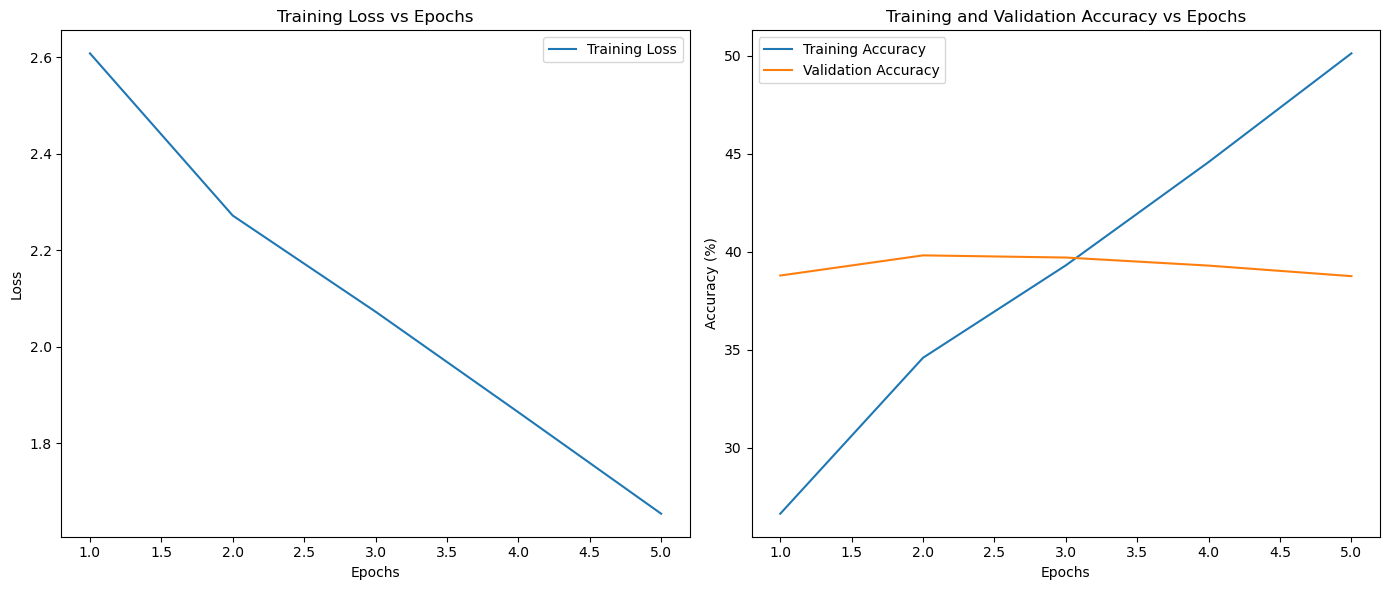

Test Accuracy: 36.80%
Precision: 0.3650
Recall: 0.3680
F1 Score: 0.3574
Test Error Rate: 63.20%
Sample 1:
Input Text: Yeah about 10 years ago I had a horrifying experience. It was 100% their fault but they hit the water barrels and survived. They had no injuries but they almost ran me off the road.
True Label: guilty
Predicted Label: devastated

Sample 2:
Input Text: No I wasn't hit. It turned out they were drunk. I felt guilty but realized it was his fault.
True Label: guilty
Predicted Label: guilty

Sample 3:
Input Text: I don't know I was new to driving and hadn't experienced anything like that. I felt like my horn made him swerve into the water barrels.
True Label: guilty
Predicted Label: impressed



In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the datasets
train_df = pd.read_csv('updated_empathetic_dialogues_train.csv', on_bad_lines='skip')
val_df = pd.read_csv('updated_empathetic_dialogues_val.csv', on_bad_lines='skip')
test_df = pd.read_csv('updated_empathetic_dialogues_test.csv', on_bad_lines='skip')

# Step 2: Label Encode the 'context' column
label_encoder = LabelEncoder()
train_df['context_encoded'] = label_encoder.fit_transform(train_df['context'])
val_df['context_encoded'] = label_encoder.transform(val_df['context'])
test_df['context_encoded'] = label_encoder.transform(test_df['context'])

# Step 3: Prepare the data
train_texts = train_df['utterance'].tolist()
train_labels = train_df['context_encoded'].tolist()
val_texts = val_df['utterance'].tolist()
val_labels = val_df['context_encoded'].tolist()
test_texts = test_df['utterance'].tolist()
test_labels = test_df['context_encoded'].tolist()

# Step 4: Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

# Convert to Torch datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels))

# Step 5: Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Step 6: Model Initialization
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_))

# Step 7: Set up the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Step 8: Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_dataloader)
    train_accuracy = correct_preds / total_preds * 100
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

    val_accuracy = correct_preds / total_preds * 100
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# Plot Training and Validation Metrics
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.tight_layout()
plt.show()

# Step 9: Evaluate on Test Set
model.eval()
correct_preds = 0
total_preds = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

# Calculate Metrics
test_accuracy = correct_preds / total_preds * 100
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
test_error_rate = 100 - test_accuracy

# Print Results
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Test Error Rate: {test_error_rate:.2f}%")

sample_indices = [0, 1, 2]  # Choose 3 sample indices for evaluation
sample_texts = [test_texts[i] for i in sample_indices]
sample_labels = [test_labels[i] for i in sample_indices]

# Tokenize and predict
input_ids = tokenizer(sample_texts, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
outputs = model(**input_ids)
logits = outputs.logits
predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Print sample results
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"Input Text: {sample_texts[i]}")
    print(f"True Label: {label_encoder.inverse_transform([sample_labels[i]])[0]}")
    print(f"Predicted Label: {label_encoder.inverse_transform([predictions[i]])[0]}")
    print()

Sample 1:
Text: Yeah_comma_ it's like they live to manipulate people for money
Actual Context: furious
Predicted Context: annoyed

Sample 2:
Text: so i decided to make a blanket and i got a sawing machine and got patterns and stuff. it tuned out to be so easy! I actually made 3 blankets
Actual Context: surprised
Predicted Context: confident

Sample 3:
Text: Its ok. It's just been rough without him. I miss him
Actual Context: sad
Predicted Context: sad



In [4]:
sample_indices = [5, 6, 7]  # Choose 3 sample indices for evaluation
sample_texts = [test_texts[i] for i in sample_indices]
sample_labels = [test_labels[i] for i in sample_indices]

# Tokenize and predict
input_ids = tokenizer(sample_texts, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
outputs = model(**input_ids)
logits = outputs.logits
predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Print sample results
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"Input Text: {sample_texts[i]}")
    print(f"True Label: {label_encoder.inverse_transform([sample_labels[i]])[0]}")
    print(f"Predicted Label: {label_encoder.inverse_transform([predictions[i]])[0]}")
    print()

Sample 1:
Input Text: I there_comma_ dont know what to do_comma_ jst broke up with my girlfirned_comma_ we were 8 years together
True Label: lonely
Predicted Label: lonely

Sample 2:
Input Text: Yes we decided together with our minds_comma_ and know i come home and feel so distant from the world
True Label: lonely
Predicted Label: lonely

Sample 3:
Input Text: I couldn't wait to go to the concert.
True Label: excited
Predicted Label: excited

